<a href="https://colab.research.google.com/github/dmbk/Anomaly-Detection-System/blob/master/ConvLSTM_ADAE_sigmoid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
!pip install imageio

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import skimage
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from PIL import Image
from tensorflow.keras import layers
import time
from tqdm import tqdm
import time
from IPython import display

from os.path import join
from os import listdir
from os.path import isfile, join, isdir

#import keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, Add, Activation, GaussianNoise, Reshape, LeakyReLU, Conv2DTranspose, Conv3DTranspose, ConvLSTM2D, BatchNormalization, LayerNormalization, TimeDistributed, Conv2D, Conv3D, ZeroPadding3D, MaxPooling2D, MaxPooling3D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential, load_model, Model
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import argparse
from os.path import dirname
import cv2
from google.colab.patches import cv2_imshow
	
from keras import backend
import tensorflow as tf
import tensorflow.keras.backend as K
keras = tf.keras
import statistics

from keras.constraints import Constraint
tf.keras.backend.set_floatx('float32')
import shutil
from matplotlib import pyplot

In [0]:
class Config:
    def __init__(self, data_dir_, cwdir_name_, data_set):
        self.data_set_name = data_set
        self.data_dir = data_dir_
        self.data_set_dir = join(self.data_dir, data_set)
        self.cwdir_name = cwdir_name_
        self.cwdir = join(self.data_dir,self.cwdir_name)
        self.run_data = join(self.cwdir, "training_gan")
        self.image_dir = join(self.run_data,self.data_set_name,"Test/")
        if not os.path.exists(self.cwdir):
            os.mkdir(self.cwdir)
            os.mkdir(self.run_data)
    
        if not os.path.exists(self.run_data):
            #shutil.rmtree(self.run_data)
            os.mkdir(self.run_data)
            os.makedirs(self.image_dir, exist_ok=True)

        self.curr_epoch = 0
        self.DATASET_PATH = join(self.data_set_dir,"Train/")
        self.TEST_DIR = join(self.data_set_dir,"Test/")
        self.BATCH_SIZE = 4
        self.EPOCHS = 25
        self.GEN_MODEL_PATH = join(self.cwdir,"model_gen_Conv2DLSTM_GAN.hdf5")
        self.DIS_MODEL_PATH = join(self.cwdir,"model_dis_Conv2DLSTM_GAN.hdf5")
        self.GAN_MODEL_PATH = join(self.cwdir,"model_combined_Conv2DLSTM_GAN.hdf5")
        self.retrain = 0
        self.curr_epoch = 1
        self.dim1 = 10
        self.dim2 = 256
        self.dim3 = 256
        self.dim4 = 1
        self.n_critic = 1
        self.r_alpha = 0.2

    def reconfig(self, new_name, batch_size = 4, epochs = 5, retrain = 0, curr_epoch = 0):
        self.cwdir_name = new_name
        self.cwdir = join(self.data_dir, self.cwdir_name)
        self.run_data = join(self.cwdir, "training_gan")
        self.image_dir = join(self.run_data,self.data_set_name,"Test/")
        
        self.BATCH_SIZE = batch_size
        self.EPOCHS = epochs
        self.GEN_MODEL_PATH = join(self.cwdir,"model_gen_Conv2DLSTM_GAN.hdf5")
        self.DIS_MODEL_PATH = join(self.cwdir,"model_dis_Conv2DLSTM_GAN.hdf5")
        self.GAN_MODEL_PATH = join(self.cwdir,"model_combined_Conv2DLSTM_GAN.hdf5")
        self.curr_epoch = 0
        self.retrain = retrain
        if retrain == 0:
            print("Configuring train from scratch")
            if not os.path.exists(self.cwdir):
                os.mkdir(self.cwdir)
                os.mkdir(self.run_data)
    
            if os.path.exists(self.run_data):
                shutil.rmtree(self.run_data)
                os.mkdir(self.run_data)
                os.makedirs(self.image_dir, exist_ok=True)
        else:
            print("Configuring retrain mode\n")
            self.final_gen_path = join(self.run_data, "generator_ep-"+str(curr_epoch)+".hdf5")
            self.final_disc_path = join(self.run_data, "discriminator_ep-"+str(curr_epoch)+".hdf5")
            self.final_gan_path = join(self.run_data, "gan_ep-"+str(curr_epoch)+".hdf5")
            self.curr_epoch = curr_epoch
            print("Last epoch saved : "+str(curr_epoch))

class ModelContainer:
    def __init__(self, y0, y1, y2):
        self.generator = y0
        self.discriminator = y1
        self.gan = y2
 
 # clip model weights to a given hypercube
class ClipConstraint(Constraint):
	# set clip value when initialized
	def __init__(self, clip_value):
		self.clip_value = clip_value

	# clip model weights to hypercube
	def __call__(self, weights):
		return backend.clip(weights, -self.clip_value, self.clip_value)

	# get the config
	def get_config(self):
		return {'clip_value': self.clip_value}
 

conf = Config(data_dir_="/content/drive/My Drive/", cwdir_name_="Conv2DLSTM_ADAE", data_set="UCSD_Anomaly_Dataset.v1p2/UCSDped1/") 
physical_devices = tf.config.list_physical_devices('GPU') 
try: 
  tf.config.experimental.set_memory_growth(physical_devices[0], True) 
except: 
  # Invalid device or cannot modify virtual devices once initialized. 
  pass

In [0]:
def get_clips_by_stride(stride, frames_list, sequence_size):

    clips = []
    sz = len(frames_list)
    clip = np.zeros(shape=(sequence_size, 256, 256, 1))
    cnt = 0
    for start in range(0, stride):
        for i in range(start, sz, stride):
            clip[cnt, :, :, 0] = frames_list[i]
            cnt = cnt + 1
            if cnt == sequence_size:
                clips.append(clip)
                cnt = 0
    return clips

def get_clips_list(seq_size):

    clips = []
    # loop over the training folders (Train000,Train001,..)
    for f in sorted(listdir(conf.DATASET_PATH)):
        directory_path = join(conf.DATASET_PATH, f)
        if isdir(directory_path):
            all_frames = []
            # loop over all the images in the folder (0.tif,1.tif,..,199.tif)
            for c in sorted(listdir(directory_path)):
                img_path = join(directory_path, c)
                if str(img_path)[-3:] == "tif":
                    img = Image.open(img_path).resize((256, 256))
                    img = np.array(img, dtype=np.float32)
                    #img = (img - 127.5)/127.5
                    #img = (2*(img - np.amin(img))/(np.amax(img) - np.amin(img)))-1
                    img = np.array(img, dtype=np.float32) / 256.0
                    all_frames.append(img)
            # get the 32-frames sequences from the list of images after applying data augmentation
            for stride in range(1, 3):
                clips.extend(get_clips_by_stride(stride=stride, frames_list=all_frames, sequence_size=seq_size))
    return clips


def get_single_test(single_test_path, sz):
    test = np.zeros(shape=(sz, conf.dim2, conf.dim3, conf.dim4))
    cnt = 0
    for f in sorted(listdir(single_test_path)):
        if str(join(single_test_path, f))[-3:] == "tif":
            img = Image.open(join(single_test_path, f)).resize((conf.dim2, conf.dim3))
            #cv2_imshow(np.array(img,dtype=np.float32))
            #cv2.waitKey(0)
            img = np.array(img, dtype=np.float32) / 256
            test[cnt, :, :, 0] = img
            cnt = cnt + 1
    return test

def get_test_sequences(test_case_dir, sz):
    test = get_single_test(join(conf.TEST_DIR,test_case_dir), sz)
    print("Test case loaded")
    sz = test.shape[0] - conf.dim1
    sequences = np.zeros((sz, conf.dim1, conf.dim2, conf.dim3, conf.dim4))
    # apply the sliding window technique to get the sequences
    for i in range(0, sz):
        clip = np.zeros((conf.dim1, conf.dim2, conf.dim3, conf.dim4))
        for j in range(0, conf.dim1):
            clip[j] = test[i + j, :, :, :]
        sequences[i] = clip
    return sequences

def convert_images_back(image):
    return np.reshape(image,(256, 256))*256.0
    #return np.reshape(image,(256, 256))*127.5 + 127.5

def evaluate(sequences, model, test_case_dir, gen_only):

    # get the reconstruction cost of all the sequences
    (reconstructed_sequences, reconstructed_sequences_2) = model.predict(sequences,batch_size=conf.BATCH_SIZE)

    sz = sequences.shape[0]
    print("Test size:"+str(sz))
    if gen_only == 1:
        os.makedirs(join(conf.image_dir,test_case_dir), exist_ok=True)
        for i in range(0, sz):
            print("sz "+str(i)+"\n")
            #cv2_imshow(np.reshape(reconstructed_sequences[i][2],(256, 256))*256)
            if i < 10:
                img_num = "00"+str(i)
            elif i < 100:
                img_num = "0"+str(i)
            else:
                img_num = str(i)    
        
            cv2.imwrite(join(conf.image_dir, test_case_dir,"gen_"+img_num+".jpg"), convert_images_back(reconstructed_sequences[i][6]))

            cv2.imwrite(join(conf.image_dir, test_case_dir,"dis_"+img_num+".jpg"), convert_images_back(reconstructed_sequences_2[i][6]))
            #cv2.waitKey()
            #print((np.reshape(reconstructed_sequences_2[i][6],(256, 256))))
            #v2_imshow(np.reshape(reconstructed_sequences_2[i][2],(256, 256))*256)
            #cv2.waitKey()

        #reconstruction_shape = (sz,10, 256, 256, 1)
    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,sz)])
    sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
    sr = 1.0 - sa

    #print(sr.shape())

    plt.plot(sr)
    plt.ylabel('regularity score Sr(t)')
    plt.xlabel('frame t')
    plt.show()

    sequences_reconstruction_cost_2 = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences_2[i])) for i in range(0,sz)])
    sa_2 = (sequences_reconstruction_cost_2 - np.min(sequences_reconstruction_cost_2)) / np.max(sequences_reconstruction_cost_2)
    sr_2 = 1.0 - sa_2
    
    #print(sr.shape())

    plt.plot(sr_2)
    plt.ylabel('regularity score Sr(t)')
    plt.xlabel('frame t')
    plt.show()

In [0]:

def get_generator():
    if conf.retrain == 1 and os.path.isfile(conf.final_gen_path):
        model=load_model(conf.final_gen_path, custom_objects={'LayerNormalization': LayerNormalization})
        return model

    init = tf.keras.initializers.RandomNormal(stddev=0.02)
    
    print("Loading generator model")
    model = Sequential()
    #model.add(GaussianNoise(0.01, input_shape=(conf.dim1, conf.dim2, conf.dim3, conf.dim4)))
    #model.add(TimeDistributed(Conv2D(128, (11, 11), strides=4, activation="relu", kernel_initializer=init, padding="same"), batch_input_shape=(None, conf.dim1, conf.dim2, conf.dim3, conf.dim4)))   
    model.add(TimeDistributed(Conv2D(128, (11, 11), strides=4, activation="relu", kernel_initializer=init, padding="same"), batch_input_shape=(None, conf.dim1, conf.dim2, conf.dim3, conf.dim4)))
    model.add(LayerNormalization())
    model.add(TimeDistributed(Conv2D(64, (5, 5), strides=2, activation="relu", kernel_initializer=init, padding="same")))
    model.add(LayerNormalization())

    # # # # #
    model.add(ConvLSTM2D(64, (3, 3), kernel_initializer=init, padding="same", return_sequences=True))
    model.add(LayerNormalization())
    model.add(ConvLSTM2D(32, (3, 3), kernel_initializer=init, padding="same", return_sequences=True))
    model.add(LayerNormalization())
    model.add(ConvLSTM2D(64, (3, 3), kernel_initializer=init, padding="same", return_sequences=True))
    model.add(LayerNormalization())
    # # # # #

    model.add(TimeDistributed(Conv2DTranspose(64, (5, 5), strides=2, activation="relu", kernel_initializer=init, padding="same")))
    model.add(LayerNormalization())
    model.add(TimeDistributed(Conv2DTranspose(128, (11, 11), strides=4, activation="relu", kernel_initializer=init, padding="same")))
    model.add(LayerNormalization())
    model.add(TimeDistributed(Conv2D(1, (11, 11), activation="sigmoid", kernel_initializer=init,  padding="same")))

    model.summary(line_length=150)
    return model


def get_discriminator():
    if conf.retrain == 1 and os.path.isfile(conf.final_disc_path):
        model=load_model(conf.final_disc_path, custom_objects={'LayerNormalization': LayerNormalization, 'ClipConstraint': ClipConstraint})
        return model

    init = tf.keras.initializers.RandomNormal(stddev=0.02)
    const = ClipConstraint(0.01)
    print("Loading discriminator model")
    model = Sequential()
    model.add(GaussianNoise(0.01, input_shape=(conf.dim1, conf.dim2, conf.dim3, conf.dim4)))
    #model.add(TimeDistributed(Conv2D(128, (11, 11), strides=4, activation="relu", kernel_initializer=init, padding="same"), batch_input_shape=(None, conf.dim1, conf.dim2, conf.dim3, conf.dim4)))   
    model.add(TimeDistributed(Conv2D(128, (11, 11), strides=4, activation="relu", kernel_initializer=init, kernel_constraint=const, padding="same"), batch_input_shape=(None, conf.dim1, conf.dim2, conf.dim3, conf.dim4)))
    model.add(LayerNormalization())
    model.add(TimeDistributed(Conv2D(64, (5, 5), strides=2, activation="relu", kernel_initializer=init, kernel_constraint=const, padding="same")))
    model.add(LayerNormalization())
    #model.add(TimeDistributed(Conv2D(64, (3, 3), strides=1, activation="relu", kernel_initializer=init, padding="same")))
    #model.add(LayerNormalization())
    # # # # #

    #model.add(TimeDistributed(Conv2D(16, (3, 3), strides=1, activation="relu", kernel_initializer=init, kernel_constraint=const, padding="same")))
    #model.add(LayerNormalization())
    #model.add(TimeDistributed(Conv2DTranspose(16, (3,3), strides=1, activation="relu", kernel_initializer=init, padding="same")))
    #model.add(LayerNormalization())
    model.add(ConvLSTM2D(64, (3, 3), kernel_initializer=init, kernel_constraint=const, padding="same", return_sequences=True))
    model.add(LayerNormalization())
    model.add(ConvLSTM2D(32, (3, 3), kernel_initializer=init, kernel_constraint=const, padding="same", return_sequences=True))
    model.add(LayerNormalization())
    model.add(ConvLSTM2D(64, (3, 3), kernel_initializer=init, kernel_constraint=const, padding="same", return_sequences=True))
    model.add(LayerNormalization())
    # # # # #

    #model.add(TimeDistributed(Conv2DTranspose(64, (3, 3), strides=1, activation="relu", kernel_initializer=init, padding="same")))
    #model.add(LayerNormalization())
    model.add(TimeDistributed(Conv2DTranspose(64, (5, 5), strides=2, activation="relu", kernel_initializer=init, padding="same")))
    model.add(LayerNormalization())
    model.add(TimeDistributed(Conv2DTranspose(128, (11, 11), strides=4, activation="relu", kernel_initializer=init, padding="same")))
    model.add(LayerNormalization())
    model.add(TimeDistributed(Conv2D(1, (11, 11), activation="sigmoid", kernel_initializer=init, padding="same")))

    model.summary(line_length=150)
    return model

def get_generator_skip_conn():
    if conf.retrain == 1 and os.path.isfile(conf.final_gen_path):
        model=load_model(conf.final_gen_path, custom_objects={'LayerNormalization': LayerNormalization})
        return model

    init = tf.keras.initializers.RandomNormal(stddev=0.02)
    
    print("Loading generator model")
    input_shape=(conf.dim1, conf.dim2, conf.dim3, conf.dim4)
    X_input = Input(input_shape)
    model = Sequential()
    
    X = TimeDistributed(Conv2D(128, (11, 11), strides=4, kernel_initializer=init, padding="same"))(X_input)
    X = LayerNormalization()(X)
    X = Activation('relu')(X)

    X = TimeDistributed(Conv2D(64, (5, 5), strides=2, kernel_initializer=init, padding="same"))(X)
    X = LayerNormalization()(X)
    X = Activation('relu')(X)
    X_skip_conn1 = X
    # # # # #
    X = ConvLSTM2D(64, (3, 3), kernel_initializer=init, padding="same", return_sequences=True)(X)
    X = LayerNormalization()(X)
    X = ConvLSTM2D(32, (3, 3), kernel_initializer=init, padding="same", return_sequences=True)(X)
    X = LayerNormalization()(X)
    X = ConvLSTM2D(64, (3, 3), kernel_initializer=init, padding="same", return_sequences=True)(X)
    X = LayerNormalization()(X)
    # # # # #
    X = Add()([X, X_skip_conn1])
    X = TimeDistributed(Conv2DTranspose(64, (5, 5), strides=2, kernel_initializer=init, padding="same"))(X)
    X = LayerNormalization()(X)
    X = Activation('relu')(X)
    
    X = TimeDistributed(Conv2DTranspose(128, (11, 11), strides=4, kernel_initializer=init, padding="same"))(X)
    X = LayerNormalization()(X)
    X = Activation('relu')(X)
    
    X = TimeDistributed(Conv2D(1, (11, 11), activation="sigmoid", kernel_initializer=init,  padding="same"))(X)

    model = Model(inputs = X_input, outputs = X, name='Generator')
    model.summary(line_length=150)
    return model


def get_discriminator_skip_conn():
    if conf.retrain == 1 and os.path.isfile(conf.final_disc_path):
        print("test1")
        model=load_model(conf.final_disc_path, custom_objects={'LayerNormalization': LayerNormalization, 'ClipConstraint': ClipConstraint})
        print("test2")
        return model

    init = tf.keras.initializers.RandomNormal(stddev=0.02)
    const = ClipConstraint(0.01)
    print("Loading discriminator model")
    input_shape=(conf.dim1, conf.dim2, conf.dim3, conf.dim4)
    X_input = Input(input_shape)
    model = Sequential()
    
    X = TimeDistributed(Conv2D(128, (11, 11), strides=4, kernel_initializer=init, kernel_constraint=const, padding="same"))(X_input)
    X = LayerNormalization()(X)
    X = Activation('relu')(X)

    X = TimeDistributed(Conv2D(64, (5, 5), strides=2, kernel_initializer=init, kernel_constraint=const, padding="same"))(X)
    X = LayerNormalization()(X)
    X = Activation('relu')(X)
    X_skip_conn1 = X

    # # # # #
    X = ConvLSTM2D(64, (3, 3), kernel_initializer=init, kernel_constraint=const, padding="same", return_sequences=True)(X)
    X = LayerNormalization()(X)
    X = ConvLSTM2D(32, (3, 3), kernel_initializer=init, kernel_constraint=const, padding="same", return_sequences=True)(X)
    X = LayerNormalization()(X)
    X = ConvLSTM2D(16, (3, 3), kernel_initializer=init, kernel_constraint=const, padding="same", return_sequences=True)(X)
    X = LayerNormalization()(X)
    X = ConvLSTM2D(32, (3, 3), kernel_initializer=init, kernel_constraint=const, padding="same", return_sequences=True)(X)
    X = LayerNormalization()(X)
    X = ConvLSTM2D(64, (3, 3), kernel_initializer=init, kernel_constraint=const, padding="same", return_sequences=True)(X)
    X = LayerNormalization()(X)
    # # # # #

    X = Add()([X, X_skip_conn1])
    X = TimeDistributed(Conv2DTranspose(64, (5, 5), strides=2, kernel_initializer=init, kernel_constraint=const, padding="same"))(X)
    X = LayerNormalization()(X)
    X = Activation('relu')(X)
    
    X = TimeDistributed(Conv2DTranspose(128, (11, 11), strides=4, kernel_initializer=init, kernel_constraint=const, padding="same"))(X)
    X = LayerNormalization()(X)
    X = Activation('relu')(X)
    
    X = TimeDistributed(Conv2D(1, (11, 11), activation="sigmoid", kernel_initializer=init, kernel_constraint=const,  padding="same"))(X)

    model = Model(inputs = X_input, outputs = X, name='Discriminator')
    model.summary(line_length=150)
    return model

def build_model(model, image_dims):
    input_img = Input(shape=image_dims)
    output = model(input_img)
    return Model(input_img,output)



#get_generator_skip_conn()
#get_discriminator_skip_conn()

In [0]:
# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, g_hist, image_name):
	# plot history
    #pyplot.plot(d1_hist, label='disc_real')
	#pyplot.plot(d2_hist, label='disc_fake')
    pyplot.plot(d1_hist, label='disc_loss')
    pyplot.plot(g_hist, label='gen')
    pyplot.legend()
    pyplot.savefig(image_name)
    pyplot.close()
 
def diff_norm(disc_x, disc_y):
    return tf.norm(tf.math.subtract(disc_x, disc_y))

def compile_gan(generator, discriminator):
    image_dims = [conf.dim1, conf.dim2, conf.dim3, conf.dim4]
    optimizer_1 = tf.keras.optimizers.Adam(lr=1e-4, decay=1e-5, epsilon=1e-6, beta_1=0.5)
    built_dis = build_model(discriminator, image_dims)
    disc_loss = diff_loss(conf.BATCH_SIZE)
    #disc_loss = HistoricalAvgLoss(built_dis, conf.BATCH_SIZE).diff_loss
    built_dis.compile(optimizer=optimizer_1, loss=disc_loss)

    built_gen = build_model(generator, image_dims)
    img = Input(shape=image_dims, dtype=tf.dtypes.float32)
    #gn_layer = GaussianNoise(0.1)(img)
    
    reconstructed_img = built_gen(img)
    
    built_dis.trainable = False
    validity = built_dis(reconstructed_img)
    optimizer = tf.keras.optimizers.Adam(lr=1e-4, decay=1e-5, epsilon=1e-6, beta_1=0.5)
    gan_model = Model(img, [reconstructed_img, validity])

    comb_loss = combined_loss()
    gan_model.compile(loss=[comb_loss, comb_loss],
    loss_weights=[1, 1],
    optimizer=optimizer)

    return ModelContainer(built_gen, built_dis, gan_model)

class HistoricalAvgLoss(object):
  def __init__(self, model, batch_size):
    # create tensors (initialized to zero) to hold the previous value of the
    # weights
    self.model = model
    self.batch_size = batch_size
    self.prev_weights = []
    for w in model.get_weights():
      self.prev_weights.append(tf.Variable(np.zeros(w.shape)))

  def loss(self, y_true, y_pred):
    err = tf.keras.losses.MSE(y_true, y_pred)
    werr = [tf.math.reduce_mean(tf.math.abs(c - p)) for c, p in zip(self.model.get_weights(), self.prev_weights)]
    self.prev_weights = tf.keras.backend.in_train_phase(
        [tf.keras.backend.update(p, c) for c, p in zip(self.model.get_weights(), self.prev_weights)],
        self.prev_weights
    )
    return tf.keras.backend.in_train_phase(err + tf.keras.backend.sum(werr), err)
  def diff_loss(self, disc_true, disc_predicted):
    loss_fake = self.loss(disc_true[:self.batch_size], disc_predicted[:self.batch_size])
    loss_real = self.loss(disc_true[self.batch_size:], disc_predicted[self.batch_size:])
    return loss_real + (1/loss_fake)

def combined_loss():

    def gen_loss_func(disc_true, disc_predicted):
        #true_flattened = flatten_over_batch(disc_true)
        #predicted_flattened = flatten_over_batch(disc_predicted)

        #loss = tf.math.log(tf.norm(tf.math.abs(tf.math.subtract(true_flattened, predicted_flattened)), ord='euclidean', axis=None, keepdims=None, name=None))
        #loss = tf.math.reduce_max([tf.match.reduce_sum(x) for x  in tf.math.abs(tf.math.subtract(true_flattened, predicted_flattened))])
        #img_pred = tf.math.l2_normalize(disc_predicted)
        loss = tf.keras.losses.MSE(disc_true, disc_predicted)
        #mse = tf.norm(tf.math.subtract(disc_true, disc_predicted))
        #loss = tf.math.sqrt(tf.math.reduce_sum(tf.math.abs(tf.math.subtract(disc_true, disc_predicted))))
        #loss = (tf.math.reduce_sum(tf.math.subtract(disc_true, disc_predicted)))
        return loss
    return gen_loss_func

def flatten_over_batch(sequence_batch):
    shape = sequence_batch.get_shape().as_list()       
    dim = np.prod(shape[1:])
    flattened_over_batch = tf.reshape(sequence_batch, [-1, dim])
    return flattened_over_batch


def diff_loss(batch_size):

    def diff_func(disc_true, disc_predicted):
        true_flattened = flatten_over_batch(disc_true)
        predicted_flattened = flatten_over_batch(disc_predicted)

        #gx_minus_dgx = tf.math.log(tf.norm(tf.math.abs(tf.math.subtract(true_flattened[:batch_size], predicted_flattened[:batch_size])), ord='euclidean', axis=None, keepdims=None, name=None))
        gx_minus_dgx = tf.keras.losses.MSE(true_flattened[:batch_size], predicted_flattened[:batch_size])
        
        #loss_fake = tf.math.reduce_max([tf.match.reduce_sum(x) for x  in tf.math.abs(tf.math.subtract(true_flattened[:batch_size], predicted_flattened[:batch_size]))])
        #x_minus_gx = tf.math.log(tf.norm(tf.math.abs(tf.math.subtract(true_flattened[batch_size:], true_flattened[:batch_size])), ord='euclidean', axis=None, keepdims=None, name=None))
        x_minus_gx = tf.keras.losses.MSE(true_flattened[batch_size:], true_flattened[:batch_size])
        
        #loss_fake = tf.keras.losses.MSE(disc_true[:batch_size], disc_predicted[:batch_size])
        #loss_fake = tf.math.sqrt(tf.math.reduce_sum(tf.math.abs(tf.math.subtract(disc_true[:batch_size], disc_predicted[:batch_size]))))
        #loss_fake = (tf.math.reduce_sum(tf.math.subtract(disc_true[:batch_size], disc_predicted[:batch_size])))
        #print(f'\t\tDiscriminator mse_real: {mse_real}\n')
        #x_minus_dx = tf.math.log(tf.norm(tf.math.abs(tf.math.subtract(true_flattened[batch_size:], predicted_flattened[batch_size:])), ord='euclidean', axis=None, keepdims=None, name=None))
        x_minus_dx = tf.keras.losses.MSE(true_flattened[batch_size:], predicted_flattened[batch_size:])
        
        #loss_real = tf.math.reduce_max([tf.match.reduce_sum(x) for x  in tf.math.abs(tf.math.subtract(true_flattened[batch_size:], predicted_flattened[batch_size:]))])
        #loss_real = tf.keras.losses.MSE(disc_true[batch_size:], disc_predicted[batch_size:])
        #loss_real = tf.math.sqrt(tf.math.reduce_sum(tf.math.abs(tf.math.subtract(disc_true[batch_size:], disc_predicted[batch_size:]))))
        #loss_real = (tf.math.reduce_sum(tf.math.subtract(disc_true[batch_size:], disc_predicted[batch_size:])))
        #print(f'\t\tDiscriminator mse_fake: {mse_fake}\n')
        term2 = tf.math.multiply(gx_minus_dgx, x_minus_gx)
        #return tf.math.add(tf.math.divide(loss_real, 2.0), tf.math.divide(1.0,tf.math.add(2.0,loss_fake)))
        return x_minus_dx - term2
    return diff_func

def train_step(models, batch_clips, c1_hist):
    
    batch_noise_clips = batch_clips
    # + tf.random.normal(shape=[conf.dim1, conf.dim2, conf.dim3, conf.dim4], stddev=0.1)
    
    batch_fake_clips = models.generator.predict_on_batch(batch_noise_clips)
    
    batch_noise_clips = tf.cast(batch_noise_clips, dtype=tf.float32)
    batch_clips = tf.cast(batch_clips, dtype=tf.float32)
    batch_fake_clips = tf.cast(batch_fake_clips, dtype=tf.float32)
    
    #disc_x = np.concatenate((batch_noise_clips, batch_fake_clips))
    disc_x = tf.concat([batch_fake_clips, batch_noise_clips], 0)
    #disc_y = np.concatenate((batch_clips, batch_fake_clips))
    disc_y = tf.concat([batch_fake_clips, batch_clips], 0)
    c1_tmp = list()
    for _ in range(conf.n_critic):
        d_loss = models.discriminator.train_on_batch(disc_x, disc_y)
        #d_loss_fake = models.discriminator.train_on_batch(batch_fake_clips, batch_fake_clips)
        #print(f'\t\tDiscriminator Loss: {d_loss}\n')
        c1_tmp.append(d_loss)
    c1_hist.append(np.mean(c1_tmp))
    
    #models.gan.train_on_batch(batch_noise_clips, [batch_clips, batch_fake_clips])
    g_loss = models.gan.train_on_batch(batch_noise_clips, [batch_clips, batch_fake_clips])
    return  g_loss
    
def reconstruct_batch(model, sequences, epoch):

    sz = sequences.shape[0]
    (reconstructed_sequences, reconstructed_sequences_2) = model.predict(sequences,batch_size=conf.BATCH_SIZE)
    path = join(conf.run_data,"Train_Reconstructs", str(epoch)+"_epoch")
    os.makedirs(path, exist_ok=True)
    for i in range(0, sz):
        #cv2_imshow(np.reshape(reconstructed_sequences[i][2],(256, 256))*256)
        if i < 10:
            img_num = "00"+str(i)
        elif i < 100:
            img_num = "0"+str(i)
        else:
            img_num = str(i)
        cv2.imwrite(join(path,"gen_"+img_num+".jpg"), convert_images_back(reconstructed_sequences[i][6]))

        cv2.imwrite(join(path,"dis_"+img_num+".jpg"), convert_images_back(reconstructed_sequences_2[i][6]))


def train(test_cases):
    discriminator = get_discriminator_skip_conn()
    generator = get_generator()
    models = compile_gan(generator, discriminator)
    models.gan.summary()

    train_dataset = tf.data.Dataset.from_tensor_slices(np.array(get_clips_list(conf.dim1))).batch(conf.BATCH_SIZE)
    c1_hist, g_hist = list(), list()
    #test_cases = get_test_sequences("Test002", 200)
    for epoch in range(conf.curr_epoch, conf.EPOCHS+1):
        print(f'Epoch {epoch+1} started')
        for batch in train_dataset:
            
            [total_weighted_loss, reconstruction_loss, fooling_loss] = train_step(models, batch, c1_hist)
            
            #print(f'Epoch: {epoch+1} \t Discriminator Loss: {fooling_loss} \t\t Generator Loss: {reconstruction_loss} \t\t Total Loss: {total_weighted_loss}')
            g_hist.append(reconstruction_loss)
            
        gen_loss_acc = statistics.mean(g_hist)
        disc_loss_acc = statistics.mean(c1_hist)
        print(f'Epoch: {epoch+1} \t Discriminator Loss: {disc_loss_acc} \t\t Generator Loss: {gen_loss_acc}')
        plot_history(c1_hist, g_hist, join(conf.run_data,"plot_line_plot_loss"+"_ep-"+str(epoch+1)+".png"))
        models.generator.save(join(conf.run_data,"generator"+"_ep-"+str(epoch+1)+".hdf5"), save_format='h5')
        models.discriminator.save(join(conf.run_data,"discriminator"+"_ep-"+str(epoch+1)+".hdf5"), save_format='h5')
        models.gan.save(join(conf.run_data,"gan"+"_ep-"+str(epoch+1)+".hdf5"), save_format='h5')
        reconstruct_batch(models.gan, test_cases[0:10*conf.BATCH_SIZE], epoch+1)

    
    models.generator.save(conf.GEN_MODEL_PATH,save_format='h5')
    models.discriminator.save(conf.DIS_MODEL_PATH,save_format='h5')
    models.gan.save(conf.GAN_MODEL_PATH, save_format='h5')
    plot_history(c1_hist, g_hist, join(conf.cwdir,"final_plot.png"))
    return models.gan



def get_model(new_cwdir, batch_size, epochs, test_cases, reconfig=0, reload=1, model_path=conf.GAN_MODEL_PATH, retrain=0, curr_epoch=0):
    if reconfig == 1:
        conf.reconfig(new_cwdir, batch_size, epochs, retrain, curr_epoch)
    if reload == 1 and os.path.isfile(model_path):
        print("Loading the trained model")
        model=load_model(model_path, custom_objects={'LeakyReLU': LeakyReLU, 'ClipConstraint': ClipConstraint, 'gen_loss_func': combined_loss(), 'diff_func': diff_loss(conf.BATCH_SIZE)})
        #model.load_weights(model_path)
    else :
        print("Loading the new model")
        model = train(test_cases)
    
    return model

Test case loaded
Configuring retrain mode

Last epoch saved : 39
Loading the trained model
Test size:190
sz 0

sz 1

sz 2

sz 3

sz 4

sz 5

sz 6

sz 7

sz 8

sz 9

sz 10

sz 11

sz 12

sz 13

sz 14

sz 15

sz 16

sz 17

sz 18

sz 19

sz 20

sz 21

sz 22

sz 23

sz 24

sz 25

sz 26

sz 27

sz 28

sz 29

sz 30

sz 31

sz 32

sz 33

sz 34

sz 35

sz 36

sz 37

sz 38

sz 39

sz 40

sz 41

sz 42

sz 43

sz 44

sz 45

sz 46

sz 47

sz 48

sz 49

sz 50

sz 51

sz 52

sz 53

sz 54

sz 55

sz 56

sz 57

sz 58

sz 59

sz 60

sz 61

sz 62

sz 63

sz 64

sz 65

sz 66

sz 67

sz 68

sz 69

sz 70

sz 71

sz 72

sz 73

sz 74

sz 75

sz 76

sz 77

sz 78

sz 79

sz 80

sz 81

sz 82

sz 83

sz 84

sz 85

sz 86

sz 87

sz 88

sz 89

sz 90

sz 91

sz 92

sz 93

sz 94

sz 95

sz 96

sz 97

sz 98

sz 99

sz 100

sz 101

sz 102

sz 103

sz 104

sz 105

sz 106

sz 107

sz 108

sz 109

sz 110

sz 111

sz 112

sz 113

sz 114

sz 115

sz 116

sz 117

sz 118

sz 119

sz 120

sz 121

sz 122

sz 123

sz 124

sz 12

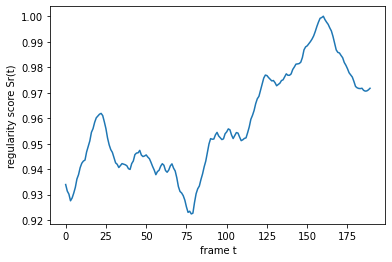

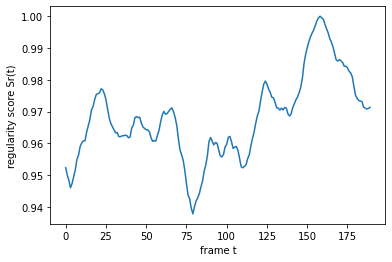

In [44]:
#!rm training_gan/gan.hdf5 -rf
#!mkdir training_gan


test_cases_dir = "Test008"
test_cases = get_test_sequences(test_cases_dir, 200)
#model_path="/content/drive/My Drive/Conv2DLSTM_VanillaGAN/training_gan/gan_ep-2.hdf5"tf.math.divide
model = get_model(new_cwdir="Conv2DLSTM_ADAE_ep50_b2_tanh", batch_size=2, epochs=50, reload=1, test_cases=test_cases, reconfig=1, retrain=1, curr_epoch=39, model_path="/content/drive/My Drive/Conv2DLSTM_ADAE_ep50_b2_tanh/training_gan/gan_ep-39.hdf5")
evaluate(test_cases, model, test_cases_dir, 1)